# fully-connected neural network

In [1]:
! conda activate tf-gpu


CondaError: Run 'conda init' before 'conda activate'



In [2]:
import json
import os
from copy import deepcopy
import random

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf

2025-04-02 19:14:39.171672: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-04-02 19:14:39.178525: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1743635679.187015  226989 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1743635679.189986  226989 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-04-02 19:14:39.199020: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

In [3]:
%load_ext autoreload
%autoreload 2

## 1. dataset

In [4]:
infile = '/home/yuan/results/epitope/epi_top_features.txt'
df = pd.read_csv(infile, sep='\t', header=0, index_col=None)
# balance the number of epitopes and non-epitopes
# df = df.iloc[:8_000_000,:]
# shuffle rows
df = df.sample(frac=1)
# df['label'] = df['label'].map({'epitope':1, 'other': 0})
df.head()

,seq,label,mean_hydro_ph7,mean_hydro,mean_polar,mean_polar_stab,mean_VDWV,median_hydro_ph7,median_hydro,median_polar,...,has_N,has_D,has_C,has_I,has_L,has_K,has_F,has_T,has_Y,has_V
1712964,TNYENGKNDYVK,1,-0.083333,0.717500,9.883333,0.161667,3.624167,-23.0,0.465,11.3,...,1,1,0,0,0,1,0,1,1,1
2376123,FKTYVDQAC,0,28.222222,0.951111,8.255556,0.168222,3.654444,41.0,1.070,8.1,...,0,1,1,0,0,1,1,1,1,1
917001,ECHSMKEKAL,1,15.600000,0.829000,9.100000,0.161300,3.522000,1.5,0.840,9.8,...,0,0,1,0,1,1,0,0,0,0
1193745,CNELNEFENNQRCMCEALQQ,1,13.800000,0.640000,9.145000,0.164200,3.575500,-10.0,0.470,10.5,...,1,0,1,0,1,0,1,0,0,0
1720646,TTQDAPEEV,0,-3.333333,0.597778,9.700000,0.124444,2.912222,-10.0,0.470,8.6,...,0,1,0,0,0,0,0,1,0,1


In [5]:
from collections import Counter

X = np.array(df.iloc[:,2:], dtype=np.float16)
is_data = X.sum(axis=0)>0
print('filter zeros:', Counter(is_data))
X = X[:,is_data]
print(X.shape, X.dtype)

y = np.array(df.iloc[:,1], dtype=np.float16)
print(y.shape, y.dtype)
Counter(y)

filter zeros: Counter({np.True_: 46})
(2490831, 46) float16
(2490831,) float16


/home/yuan/anaconda3/envs/tf-gpu/lib/python3.11/site-packages/numpy/_core/_methods.py:52: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial, where)


Counter({np.float16(1.0): 1798795, np.float16(0.0): 692036})

In [6]:
# normalization X
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
norm_X = scaler.fit_transform(X)

In [7]:
#split data into train and test
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, shuffle=True, random_state=2)
X_train, X_validate, y_train, y_validate = train_test_split(X_train, y_train, train_size=0.7, shuffle=True, random_state=2)
print(X_train.shape, y_train.shape)
print(X_validate.shape, y_validate.shape)
print(X_test.shape, y_test.shape)

(1394864, 46) (1394864,)
(597800, 46) (597800,)
(498167, 46) (498167,)


## 2. train model

In [8]:
from tensorflow.keras.layers import Input, Dense, Dropout

# input features
num_features = int(X.shape[-1])
# outccome is binary
model = tf.keras.Sequential([
    Input(shape=(num_features,)),
    Dense(512, activation='relu'),
    Dropout(0.3),
    Dense(96, activation='relu'),
    Dropout(0.3),
    Dense(1, activation='sigmoid'),
])
model.summary()

I0000 00:00:1743635692.364488  226989 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 9176 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3060, pci bus id: 0000:01:00.0, compute capability: 8.6


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 512)            │        24,064 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 96)             │        49,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 96)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            97 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 73,409 (286.75 KB)

 Trainable params: 73,409 (286.75 KB)

 Non-trainable params: 0 (0.00 B)

In [9]:
# loss_fn = tf.keras.losses.sparse_categorical_crossentropy
optim = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(
    loss='binary_crossentropy',
    optimizer=optim,
    metrics=['accuracy', 'precision', 'recall', 'auc', 'mse']
)

epochs = 10
history= model.fit(
    X_train,
    y_train,
    validation_data=(X_validate, y_validate),
    epochs=epochs,
    verbose=True
)

res = pd.DataFrame(history.history)
print(res.head(3))
print(res.tail(3))

Epoch 1/10


I0000 00:00:1743635693.859274  227113 service.cc:148] XLA service 0x716424017570 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1743635693.859291  227113 service.cc:156]   StreamExecutor device (0): NVIDIA GeForce RTX 3060, Compute Capability 8.6
2025-04-02 19:14:53.879381: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1743635693.954666  227113 cuda_dnn.cc:529] Loaded cuDNN version 90800


  109/43590 ━━━━━━━━━━━━━━━━━━━━ 1:01 1ms/step - accuracy: 0.6138 - auc: 0.5054 - loss: 29.5350 - mse: 0.3717 - precision: 0.7327 - recall: 0.7434

I0000 00:00:1743635694.512881  227113 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


43590/43590 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7203 - auc: 0.5076 - loss: 0.8783 - mse: 0.2045 - precision: 0.7228 - recall: 0.9940

E0000 00:00:1743635753.401584  227111 buffer_comparator.cc:157] Difference at 16: 0, expected 260.803
E0000 00:00:1743635753.401609  227111 buffer_comparator.cc:157] Difference at 17: 0, expected 274.951
E0000 00:00:1743635753.401611  227111 buffer_comparator.cc:157] Difference at 18: 0, expected 253.659
E0000 00:00:1743635753.401612  227111 buffer_comparator.cc:157] Difference at 19: 0, expected 257.607
E0000 00:00:1743635753.401613  227111 buffer_comparator.cc:157] Difference at 20: 0, expected 250.262
E0000 00:00:1743635753.401614  227111 buffer_comparator.cc:157] Difference at 21: 0, expected 258.782
E0000 00:00:1743635753.401615  227111 buffer_comparator.cc:157] Difference at 22: 0, expected 253.591
E0000 00:00:1743635753.401616  227111 buffer_comparator.cc:157] Difference at 23: 0, expected 258.759
E0000 00:00:1743635753.401618  227111 buffer_comparator.cc:157] Difference at 24: 0, expected 259.406
E0000 00:00:1743635753.401619  227111 buffer_comparator.cc:157] Difference at 25: 

43590/43590 ━━━━━━━━━━━━━━━━━━━━ 79s 2ms/step - accuracy: 0.7203 - auc: 0.5076 - loss: 0.8783 - mse: 0.2045 - precision: 0.7228 - recall: 0.9940 - val_accuracy: 0.7228 - val_auc: 0.5070 - val_loss: 0.5902 - val_mse: 0.2003 - val_precision: 0.7228 - val_recall: 0.9997
Epoch 2/10
43590/43590 ━━━━━━━━━━━━━━━━━━━━ 66s 2ms/step - accuracy: 0.7238 - auc: 0.5142 - loss: 0.5889 - mse: 0.1996 - precision: 0.7247 - recall: 0.9952 - val_accuracy: 0.7266 - val_auc: 0.5268 - val_loss: 0.5847 - val_mse: 0.1979 - val_precision: 0.7269 - val_recall: 0.9954
Epoch 3/10
43590/43590 ━━━━━━━━━━━━━━━━━━━━ 69s 2ms/step - accuracy: 0.7289 - auc: 0.5977 - loss: 0.5742 - mse: 0.1932 - precision: 0.7347 - recall: 0.9776 - val_accuracy: 0.7470 - val_auc: 0.6909 - val_loss: 0.5391 - val_mse: 0.1786 - val_precision: 0.7595 - val_recall: 0.9508
Epoch 4/10
43590/43590 ━━━━━━━━━━━━━━━━━━━━ 70s 2ms/step - accuracy: 0.7375 - auc: 0.6671 - loss: 0.5525 - mse: 0.1843 - precision: 0.7475 - recall: 0.9607 - val_accuracy: 0.

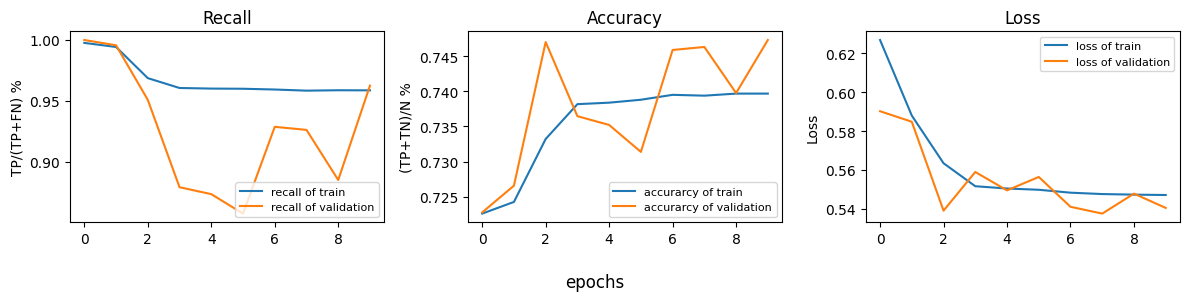

In [10]:
fig, axes = plt.subplots(1, 3, figsize=(12,3), layout='tight')
x = range(epochs)
fig.supxlabel('epochs')

i=0
axes[i].plot(x, history.history['recall'], label='recall of train')
axes[i].plot(x, history.history['val_recall'], label='recall of validation')
axes[i].set_ylabel('TP/(TP+FN) %')
axes[i].set_title('Recall')
axes[i].legend(loc='lower right', fontsize=8)

i=1
axes[i].plot(x, history.history['accuracy'], label='accurarcy of train')
axes[i].plot(x, history.history['val_accuracy'], label='accurarcy of validation')
axes[i].set_ylabel('(TP+TN)/N %')
axes[i].set_title('Accuracy')
axes[i].legend(loc='lower right', fontsize=8)

i=2
axes[i].plot(x, history.history['loss'], label='loss of train')
axes[i].plot(x, history.history['val_loss'], label='loss of validation')
axes[i].set_ylabel('Loss')
axes[i].set_title('Loss')
axes[i].legend(loc='upper right', fontsize=8)

In [11]:
eval_res = model.evaluate(X_test, y_test, return_dict=True)
print(eval_res)

15563/15568 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7488 - auc: 0.7043 - loss: 0.5398 - mse: 0.1790 - precision: 0.7562 - recall: 0.9627

E0000 00:00:1743636419.223212  227115 buffer_comparator.cc:157] Difference at 16: 1, expected 259.638
E0000 00:00:1743636419.223238  227115 buffer_comparator.cc:157] Difference at 17: 0, expected 272.882
E0000 00:00:1743636419.223240  227115 buffer_comparator.cc:157] Difference at 18: 0, expected 253.696
E0000 00:00:1743636419.223241  227115 buffer_comparator.cc:157] Difference at 19: 1, expected 256.667
E0000 00:00:1743636419.223242  227115 buffer_comparator.cc:157] Difference at 20: 1, expected 245.546
E0000 00:00:1743636419.223243  227115 buffer_comparator.cc:157] Difference at 21: 0, expected 250.479
E0000 00:00:1743636419.223244  227115 buffer_comparator.cc:157] Difference at 22: 27.4375, expected 252.782
E0000 00:00:1743636419.223246  227115 buffer_comparator.cc:157] Difference at 23: 1.21582, expected 261.97
E0000 00:00:1743636419.223247  227115 buffer_comparator.cc:157] Difference at 24: 7.875, expected 262.476
E0000 00:00:1743636419.223248  227115 buffer_comparator.cc:157] Dif

15568/15568 ━━━━━━━━━━━━━━━━━━━━ 17s 1ms/step - accuracy: 0.7488 - auc: 0.7043 - loss: 0.5398 - mse: 0.1790 - precision: 0.7562 - recall: 0.9627
{'accuracy': 0.7475886344909668, 'auc': 0.7028059363365173, 'loss': 0.5406678318977356, 'mse': 0.17942272126674652, 'precision': 0.7552650570869446, 'recall': 0.9624223709106445}


In [12]:
pred_test = model.predict(X_test)
pred_test[:3]

15568/15568 ━━━━━━━━━━━━━━━━━━━━ 6s 361us/step


array([[0.73696214],
       [0.45623824],
       [0.69687355]], dtype=float32)

Text(0.5, 1.0, 'Prediction of non-epitopes 138325')

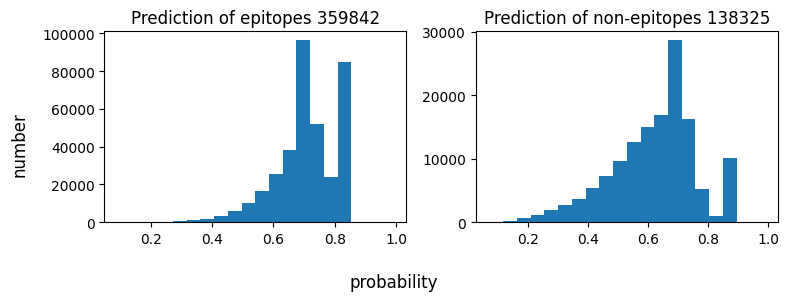

In [13]:

t = pred_test[y_test==1]
f = pred_test[y_test==0]
fig, ax = plt.subplots(1, 2, figsize=(8,3), layout='tight')
fig.supxlabel('probability')
fig.supylabel('number')

ax[0].hist(t, label='True', bins=20)
ax[0].set_title(f'Prediction of epitopes {len(t)}')
ax[1].hist(f, label='False', bins=20)
ax[1].set_title(f'Prediction of non-epitopes {len(f)}')

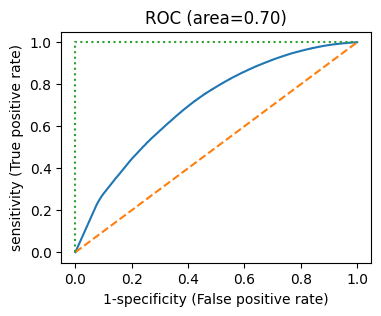

In [14]:
# ROC curve only for binary classfication
from sklearn.metrics import roc_curve, auc
# FPR, false positive rate, 1- specificity, typ I error
# TPR, true positive rate, sensitivity, power
fpr, tpr, thresholds = roc_curve(y_test, pred_test)
roc_auc = auc(fpr, tpr)

fig, ax = plt.subplots(1, figsize=(4,3))
ax.plot(fpr, tpr)
ax.set_xlabel('1-specificity (False positive rate)')
ax.set_ylabel('sensitivity (True positive rate)')
plt.title(f'ROC (area={roc_auc:.2f})')
ax.plot([0,1], [0,1], '--')
ax.plot([0,0,1], [0,1,1], ':')

In [15]:
# save entire model
model.save('../models/epitopes_ann_normX.keras')

(array([3.67000e+02, 2.10400e+03, 5.93900e+03, 1.31960e+04, 3.07620e+04,
        6.70700e+04, 1.69717e+05, 1.11815e+05, 9.71630e+04, 3.40000e+01]),
 array([0.07170656, 0.1633117 , 0.25491685, 0.346522  , 0.43812716,
        0.52973229, 0.62133741, 0.7129426 , 0.80454773, 0.89615285,
        0.98775804]),
 <BarContainer object of 10 artists>)

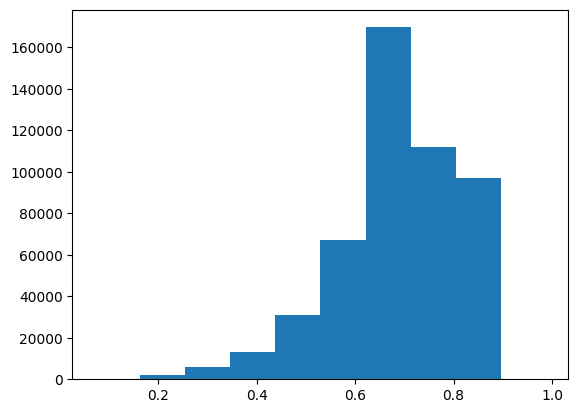

In [16]:
plt.hist(pred_test)

(array([138325.,      0.,      0.,      0.,      0.,      0.,      0.,
             0.,      0., 359842.]),
 array([0.        , 0.09997559, 0.19995117, 0.29980469, 0.39990234,
        0.5       , 0.59960938, 0.69970703, 0.79980469, 0.89990234,
        1.        ]),
 <BarContainer object of 10 artists>)

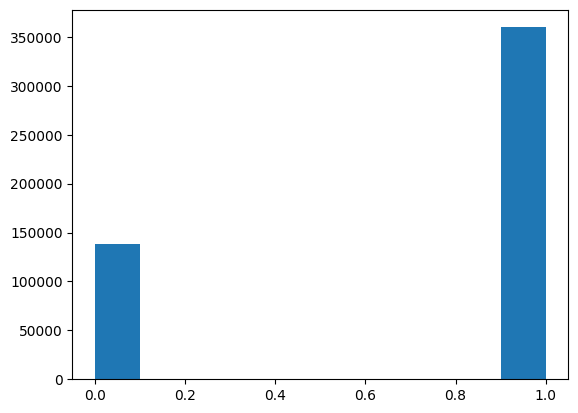

In [17]:
plt.hist(y_test)